In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')


In [19]:
all_data = pd.concat([df_train, df_test])
print(f'Size of train data: {df_train.shape}')
print(f'Size of test data: {df_test.shape}')
print(f'Size of all data: {all_data.shape}')
print(all_data.columns)


Size of train data: (891, 12)
Size of test data: (418, 11)
Size of all data: (1309, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## Project planning
1) Understanding data
2) Histograms and boxplots
3) Value counts
4) Missing data
5) Correlation between metrics
6) Explore interesting themes
    * Wealthy survive?
    * By location
    * Age scatterplot with ticket price
    * Young and wealthy variable?
    * Total spent?
7) Feature engineering
8) Preprocess data together or use a transformer?
    * use label for train and test
9) Scaling?

10) Model Baseline
11) Model comparison with CV

## Data exploration

In [20]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Here we can see, that we have missing values in age and cabin columns

In [23]:
# df_train.describe()
df_train.head(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [27]:
df_numerical = df_train[['Age', 'SibSp', 'Parch', 'Fare']]
df_categorical = df_train[['Survived', 'Pclass',
                           'Sex', 'Ticket', 'Cabin', 'Embarked']]

df_numerical


,Age,SibSp,Parch,Fare
0,22.0,1,0,7.2500
1,38.0,1,0,71.2833
2,26.0,0,0,7.9250
3,35.0,1,0,53.1000
4,35.0,0,0,8.0500
...,...,...,...,...
886,27.0,0,0,13.0000
887,19.0,0,0,30.0000
888,NaN,1,2,23.4500
889,26.0,0,0,30.0000


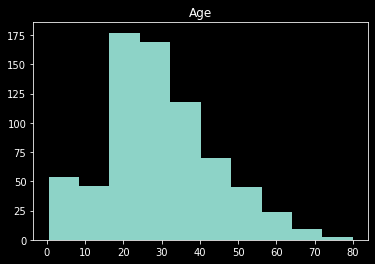

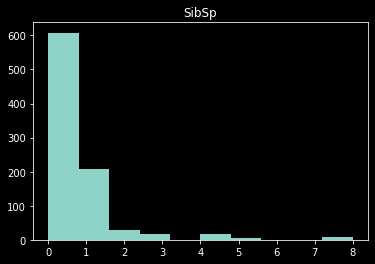

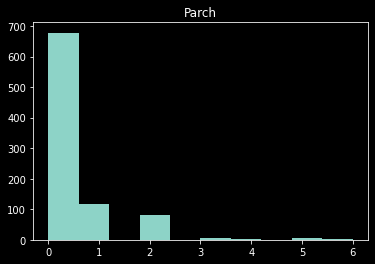

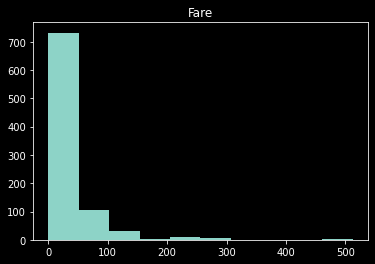

In [30]:
for i in df_numerical.columns:
    plt.hist(df_train[i])
    plt.title(i)
    plt.show()


Age have normal distribution

Normalizing Fare?

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<AxesSubplot:>

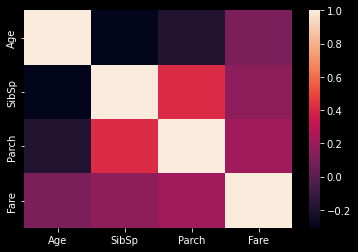

In [34]:
print(df_numerical.corr())
sns.heatmap(df_numerical.corr())


In [35]:
# compare survival rate between groups by Age, SibSp, Parch, Fare
pd.pivot_table(df_train, index='Survived', values=[
               'Age', 'SibSp', 'Parch', 'Fare'])


,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


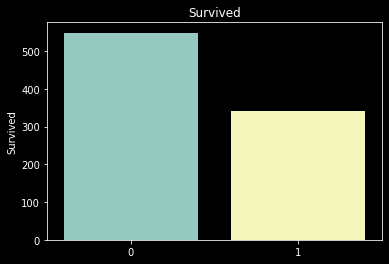

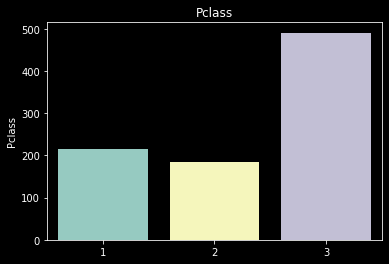

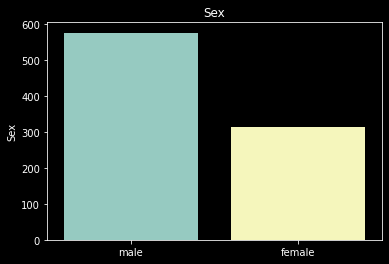

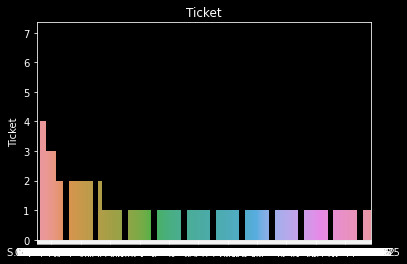

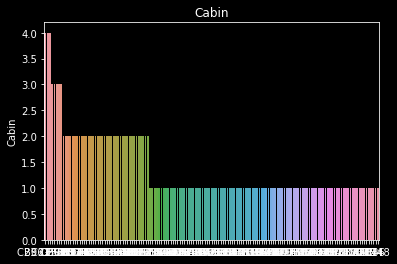

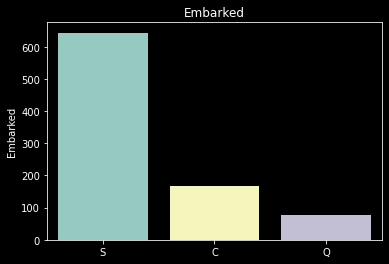

In [39]:
# look at distribution of categorical variables
# graphics show count of each value
for col in df_categorical.columns:
    sns.barplot(x=df_categorical[col].value_counts(
    ).index, y=df_categorical[col].value_counts()).set_title(col)
    plt.show()


In [45]:
# comparing survival and each of these categorical variables
# print(pd.pivot_table(df_train, index = 'Survived', columns = 'Pclass', values = 'Ticket', aggfunc='count'))
print(pd.pivot_table(df_train, index='Survived',
      columns='Pclass', values='Ticket', aggfunc='count'))
print()

print(pd.pivot_table(df_train, index='Survived',
      columns='Sex', values='Ticket', aggfunc='count'))
print()

print(pd.pivot_table(df_train, index='Survived',
      columns='Embarked', values='Ticket', aggfunc='count'))
print()


Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217



This tables show us, that 'women and children first' applied in this scenario

## Feature Engineering
1) Cabin - simplify cabins (evaluated if cabin letter (cabin_adv) or the purchase of tickets across multiple cabins (cabins_multiple) impacted survival)

2) Tickets - Do different ticket types impact survival rates?

3) Does a person's title relate to survival rates?

### Cabins

In [ ]:
# if person haven't room place 0, elif he have one or more rooms, then place count of rooms
# in the table if person have several rooms, they are listed separated by a space

# example:
print(f"Person who have not room - {df_train['Cabin'].iloc[0]}")
print(f"Person who have one room - {df_train['Cabin'].iloc[3]}")
print(f"Person who have several rooms - {df_train['Cabin'].iloc[27]}")

df_train['cabin_multiple'] = df_train['Cabin'].apply(
    lambda x: 0 if pd.isna(x) else len(x.split(' ')))

df_train['cabin_multiple'].value_counts()


In [59]:
# looks survival rate between groups by cabin count
pd.pivot_table(df_train, index='Survived',
               columns='cabin_multiple', values='Ticket', aggfunc='count')


cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [60]:
# creates categories based on the cabin letter (n stands for null)
# in this case we will treat null values like it's own category

df_train['cabin_adv'] = df_train['Cabin'].apply(lambda x: str(x)[0])


In [62]:
print(df_train['cabin_adv'].value_counts())

# looks survival rate between groups by cabin adv
pd.pivot_table(df_train, index='Survived', columns='cabin_adv',
               values='Name', aggfunc='count')


n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_adv, dtype: int64


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


We can use cabin letter categorical feature, and it may help us

### Tickets

In [69]:
# understanding ticket values better
# Tickets can be numeric or non numeric
# examples:
print(df_train['Ticket'].iloc[0])
print(df_train['Ticket'].iloc[3])

# if ticket name include only digits it's numeric, else non numeric
df_train['numeric_ticket'] = df_train['Ticket'].apply(
    lambda x: 1 if x.isnumeric() else 0)

df_train['ticket_letters'] = df_train['Ticket'].apply(lambda x: ''.join(x.split(
    ' ')[:-1]).replace('.', '').replace('/', '').lower() if len(x.split(' ')[:-1]) > 0 else 0)


A/5 21171
113803


In [71]:
df_train['numeric_ticket'].value_counts()

1    661
0    230
Name: numeric_ticket, dtype: int64

In [74]:
df_train['ticket_letters'].value_counts()

0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
fcc            5
c              5
sopp           3
pp             3
wep            3
ppp            2
scah           2
sotono2        2
swpp           2
fc             1
scahbasle      1
as             1
sp             1
sc             1
scow           1
fa             1
sop            1
sca4           1
casoton        1
Name: ticket_letters, dtype: int64

In [77]:
# looks survival rate between groups by numeric ticket
pd.pivot_table(df_train, index='Survived', columns='numeric_ticket',
               values='Name', aggfunc='count')


numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [78]:
# survival rate across different tyicket types
pd.pivot_table(df_train, index='Survived',
               columns='ticket_letters', values='Ticket', aggfunc='count')


ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


### Names

In [81]:
#feature engineering on person's title 
df_train['name_title'] = df_train.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
df_train.Name.head(50)
#mr., ms., master. etc

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [83]:
df_train['name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: name_title, dtype: int64

In [86]:
# maybe some royalty person have more chances to survive
pd.pivot_table(df_train, index='Survived', columns='name_title',
               values='Name', aggfunc='count')


name_title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,4.0,1.0,NaN,1.0,17.0,55.0,NaN,NaN,436.0,26.0,NaN,6.0,NaN,NaN
1,NaN,1.0,NaN,3.0,NaN,1.0,1.0,23.0,127.0,2.0,1.0,81.0,99.0,1.0,NaN,1.0,1.0


# Data preprocessing for model